# $\Phi$-SO demo

## Packages import

In [1]:
# conda env
!echo $CONDA_PREFIX

/opt/homebrew/Caskroom/miniforge/base/envs/PhySO


In [2]:
# External packages
import torch
import os
import time as time
import numpy as np

# Pyplot
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from sklearn.neighbors import KernelDensity
from IPython.display import display, clear_output


In [3]:
# Internal code import
import physo
from physo.physym import batch as Batch 
from physo.physym import execute as ExecuteProgram
from physo.physym import program as Program
from physo.physym import reward as Reward
from physo.learn  import monitoring
from physo.task   import benchmark


In [4]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(DEVICE)

cpu


In [5]:
torch.cuda.is_available()

False

## ML utils

## Test case

In [6]:
data_size = 50

In [7]:
# Data points
data_lowbound, data_upbound = -10, 10
z  = np.random.uniform(data_lowbound, data_upbound, data_size)
vz = np.random.uniform(data_lowbound, data_upbound, data_size)
x0_array = z
x1_array = vz
X_array = np.stack((x0_array, x1_array), axis=0)
m = 1.5
g = 9.8
y_array = m*g*z + m*vz**2 #+ 0.5*m*vz**2

# One of many symbolic solutions:
target_program_str = ["add", "mul", "mul", "m", "g", "z", "mul", "m", "n2", "v_z"]
# ["add", "mul", "mul", "m", "g", "z", "mul", "m", "n2", "vz"]
# ["add", "mul", "mul", "m", "g", "z", "mul", "mul", "inv", "add", "1", "1", "m", "n2", "vz"]
print(len(target_program_str))


10


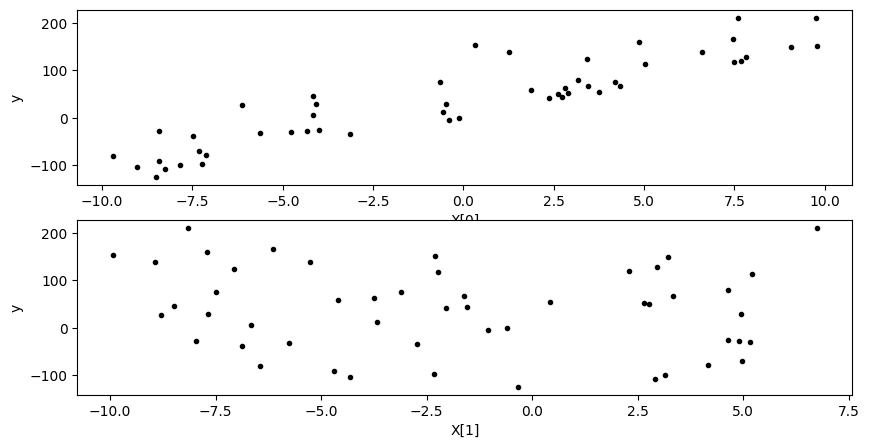

In [8]:
n_dim = X_array.shape[0]
fig, ax = plt.subplots(n_dim, 1, figsize=(10,5))
for i in range (n_dim):
    curr_ax = ax if n_dim==1 else ax[i]
    curr_ax.plot(X_array[i], y_array, 'k.',)
    curr_ax.set_xlabel("X[%i]"%(i))
    curr_ax.set_ylabel("y")
plt.show()

In [9]:
# ------ Vectors ------
# Stack of all input variables
X = torch.tensor(X_array).to(DEVICE)
# Output of symbolic function to guess
y = torch.tensor(y_array).to(DEVICE)

# ------ Constants ------
const1 = torch.tensor(np.array(1.)).to(DEVICE)
m = torch.tensor(np.array(m)).to(DEVICE)
g = torch.tensor(np.array(g)).to(DEVICE)

## Run config

### Library config

In [10]:
args_make_tokens = {
                # operations
                "op_names"             : ["mul", "add", "sub", "div", "inv", "n2", "sqrt", "exp", "log", "sin", "cos"],
                "use_protected_ops"    : True,
                # input variables
                "input_var_ids"        : {"z" : 0         , "v_z" : 1         , },
                "input_var_units"      : {"z" : [1, 0, 0] , "v_z" : [1, -1, 0], },
                "input_var_complexity" : {"z" : 1.        , "v_z" : 1.        , },
                # constants
                "constants"            : {"1" : const1    , },
                "constants_units"      : {"1" : [0, 0, 0] , },
                "constants_complexity" : {"1" : 1.        , },
                # free constants
                "free_constants"            : {"m"              , "g"              ,},
                "free_constants_init_val"   : {"m" : 1.         , "g" : 1.         ,},
                "free_constants_units"      : {"m" : [0, 0, 1]  , "g" : [1, -2, 0] ,},
                "free_constants_complexity" : {"m" : 1.         , "g" : 1.         ,},
                    }

library_config = {"args_make_tokens"  : args_make_tokens,
                  "superparent_units" : [2, -2, 1],
                  "superparent_name"  : "E",
                }

### Free constant optimizer config

In [11]:
free_const_opti_args = {
            'loss'   : "MSE",
            'method' : 'LBFGS',
            'method_args': {
                        'n_steps' : 30,
                        'tol'     : 1e-8,
                        'lbfgs_func_args' : {
                            'max_iter'       : 4,
                            'line_search_fn' : "strong_wolfe",
                                             },
                            },
        }

### Learning config

In [12]:
MAX_TRIAL_EXPRESSIONS = 2*1e6
BATCH_SIZE = int(1e3)
MAX_LENGTH = 35
GET_OPTIMIZER = lambda model : torch.optim.Adam(
                                    model.parameters(),                
                                    lr=0.0025, #0.001, #0.0050, #0.0005, #1,  #lr=0.0025
                                                )

In [13]:
reward_config = {
                 "reward_function"     : Reward.SquashedNRMSE,
                 "zero_out_unphysical" : True,
                }

In [14]:
learning_config = {
    # Batch related
    'batch_size'       : BATCH_SIZE,
    'max_time_step'    : MAX_LENGTH,
    'n_epochs'         : int(1e9), #int(MAX_TRIAL_EXPRESSIONS/BATCH_SIZE),
    # Loss related
    'gamma_decay'      : 0.7,
    'entropy_weight'   : 0.005,
    # Reward related
    'risk_factor'      : 0.05,
    'rewards_computer' : Reward.make_RewardsComputer (**reward_config),
    # Optimizer
    'get_optimizer'    : GET_OPTIMIZER,
}

### Priors config

In [15]:
priors_config  = [
                #("UniformArityPrior", None),
                # LENGTH RELATED
                ("HardLengthPrior"  , {"min_length": 4, "max_length": MAX_LENGTH, }),
                ("SoftLengthPrior"  , {"length_loc": 6, "scale": 5, }),
                # RELATIONSHIPS RELATED
                ("NoUselessInversePrior"  , None),
                ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}), # PHYSICALITY
                #("NestedFunctions", {"functions":["exp",], "max_nesting" : 1}),
                #("NestedFunctions", {"functions":["log",], "max_nesting" : 1}),
                ("NestedTrigonometryPrior", {"max_nesting" : 1}),              
                 ]

### Cell config

In [16]:
cell_config = {
    "hidden_size" : 128,
    "n_layers"    : 1,
}

### Logger

In [17]:
run_logger     = monitoring.RunLogger()
save_path_training_curves = 'model11k-MechanicalEnergy-run.png'
run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = 1,
                                           save_path = save_path_training_curves,
                                           do_show   = True,
                                           do_save   = True, )

### Run config

In [18]:
run_config = {
    "learning_config"      : learning_config,
    "reward_config"        : reward_config,
    "free_const_opti_args" : free_const_opti_args,
    "library_config"       : library_config,
    "priors_config"        : priors_config,
    "cell_config"          : cell_config,
    "run_logger"           : run_logger,
    "run_visualiser"       : run_visualiser,
}

## Dummy epoch for prior tuning

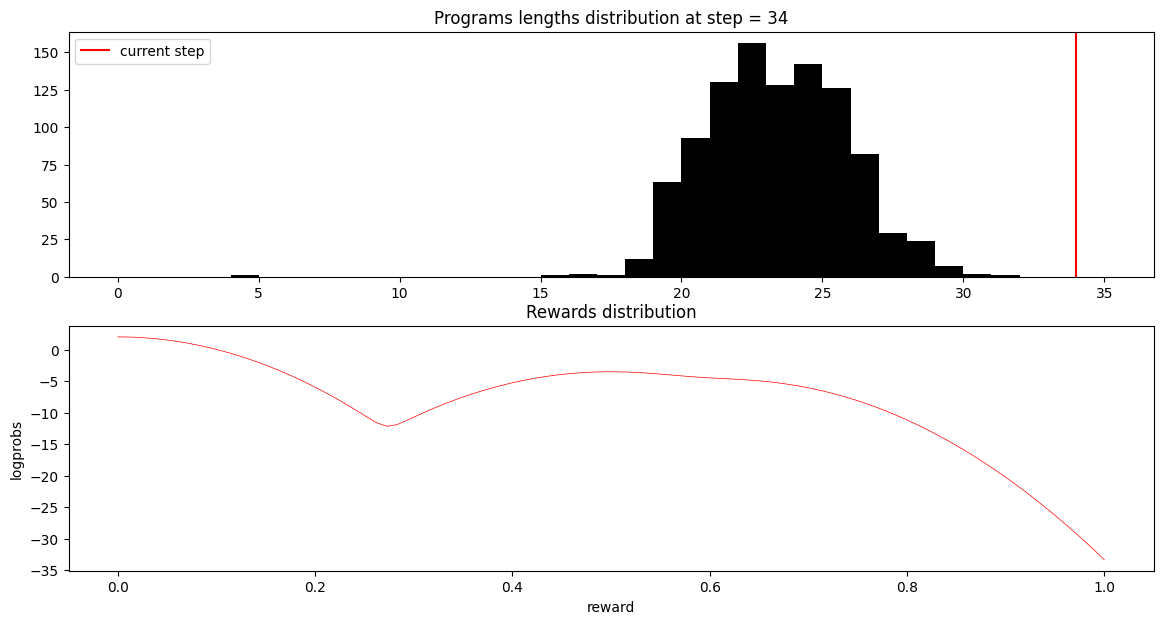

In [19]:
benchmark.dummy_epoch(X, y, run_config)

## Sanity checks

Data


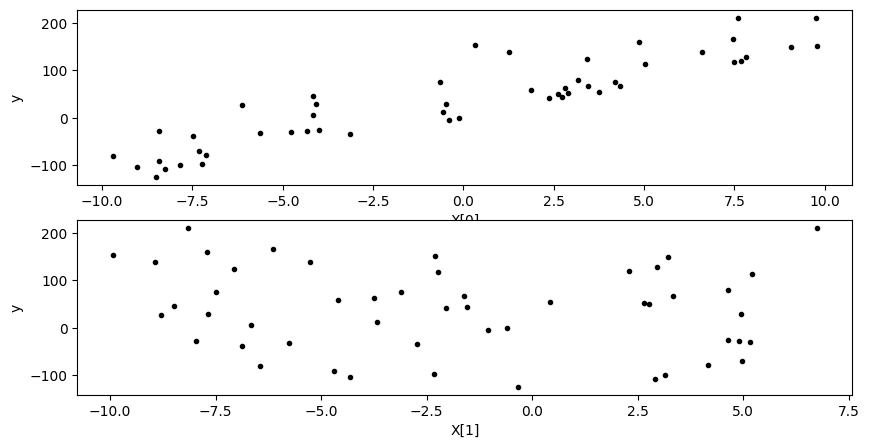

{'mul': 0, 'add': 1, 'sub': 2, 'div': 3, 'inv': 4, 'n2': 5, 'sqrt': 6, 'exp': 7, 'log': 8, 'sin': 9, 'cos': 10, '1': 11, 'g': 12, 'm': 13, 'z': 14, 'v_z': 15}
-------------------------- Library -------------------------
[mul add sub div inv n2 sqrt exp log sin cos 1 g m z v_z E dummy -]
--------------------------- Prior --------------------------
PriorCollection:
- HardLengthPrior (min_length = 4, max_length = 35)
- SoftLengthPrior (length_loc = 6, scale = 5)
- NoUselessInversePrior (['inv', 'log', 'exp', 'n2', 'sqrt'] can not be child of ['inv', 'exp', 'log', 'sqrt', 'n2'])
- PhysicalUnitsPrior
- NestedTrigonometryPrior (tokens = ['sin' 'cos'], nesting forbidden)
-------------------------- Dataset -------------------------
X        : torch.Size([2, 50]) 
y_target : torch.Size([50])
-------------------------- Programs ------------------------
[['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' ... '-' '-' '-']
 ...
 ['dummy' '-' '-' ... '-' '-' '-']


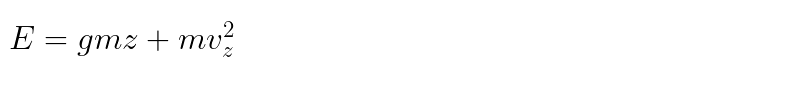

Simplified expression:


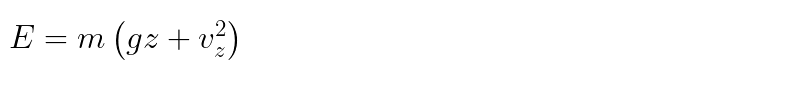

Ideal reward : 0.9999997583106299


In [20]:
target_program = benchmark.sanity_check(X, y, run_config, target_program_str=target_program_str)

## Run

  -> epoch 00013


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x28dd26280>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/PhySO/lib/python3.8/site-packages/matplotlib/transforms.py", line 222, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 


KeyboardInterrupt: 

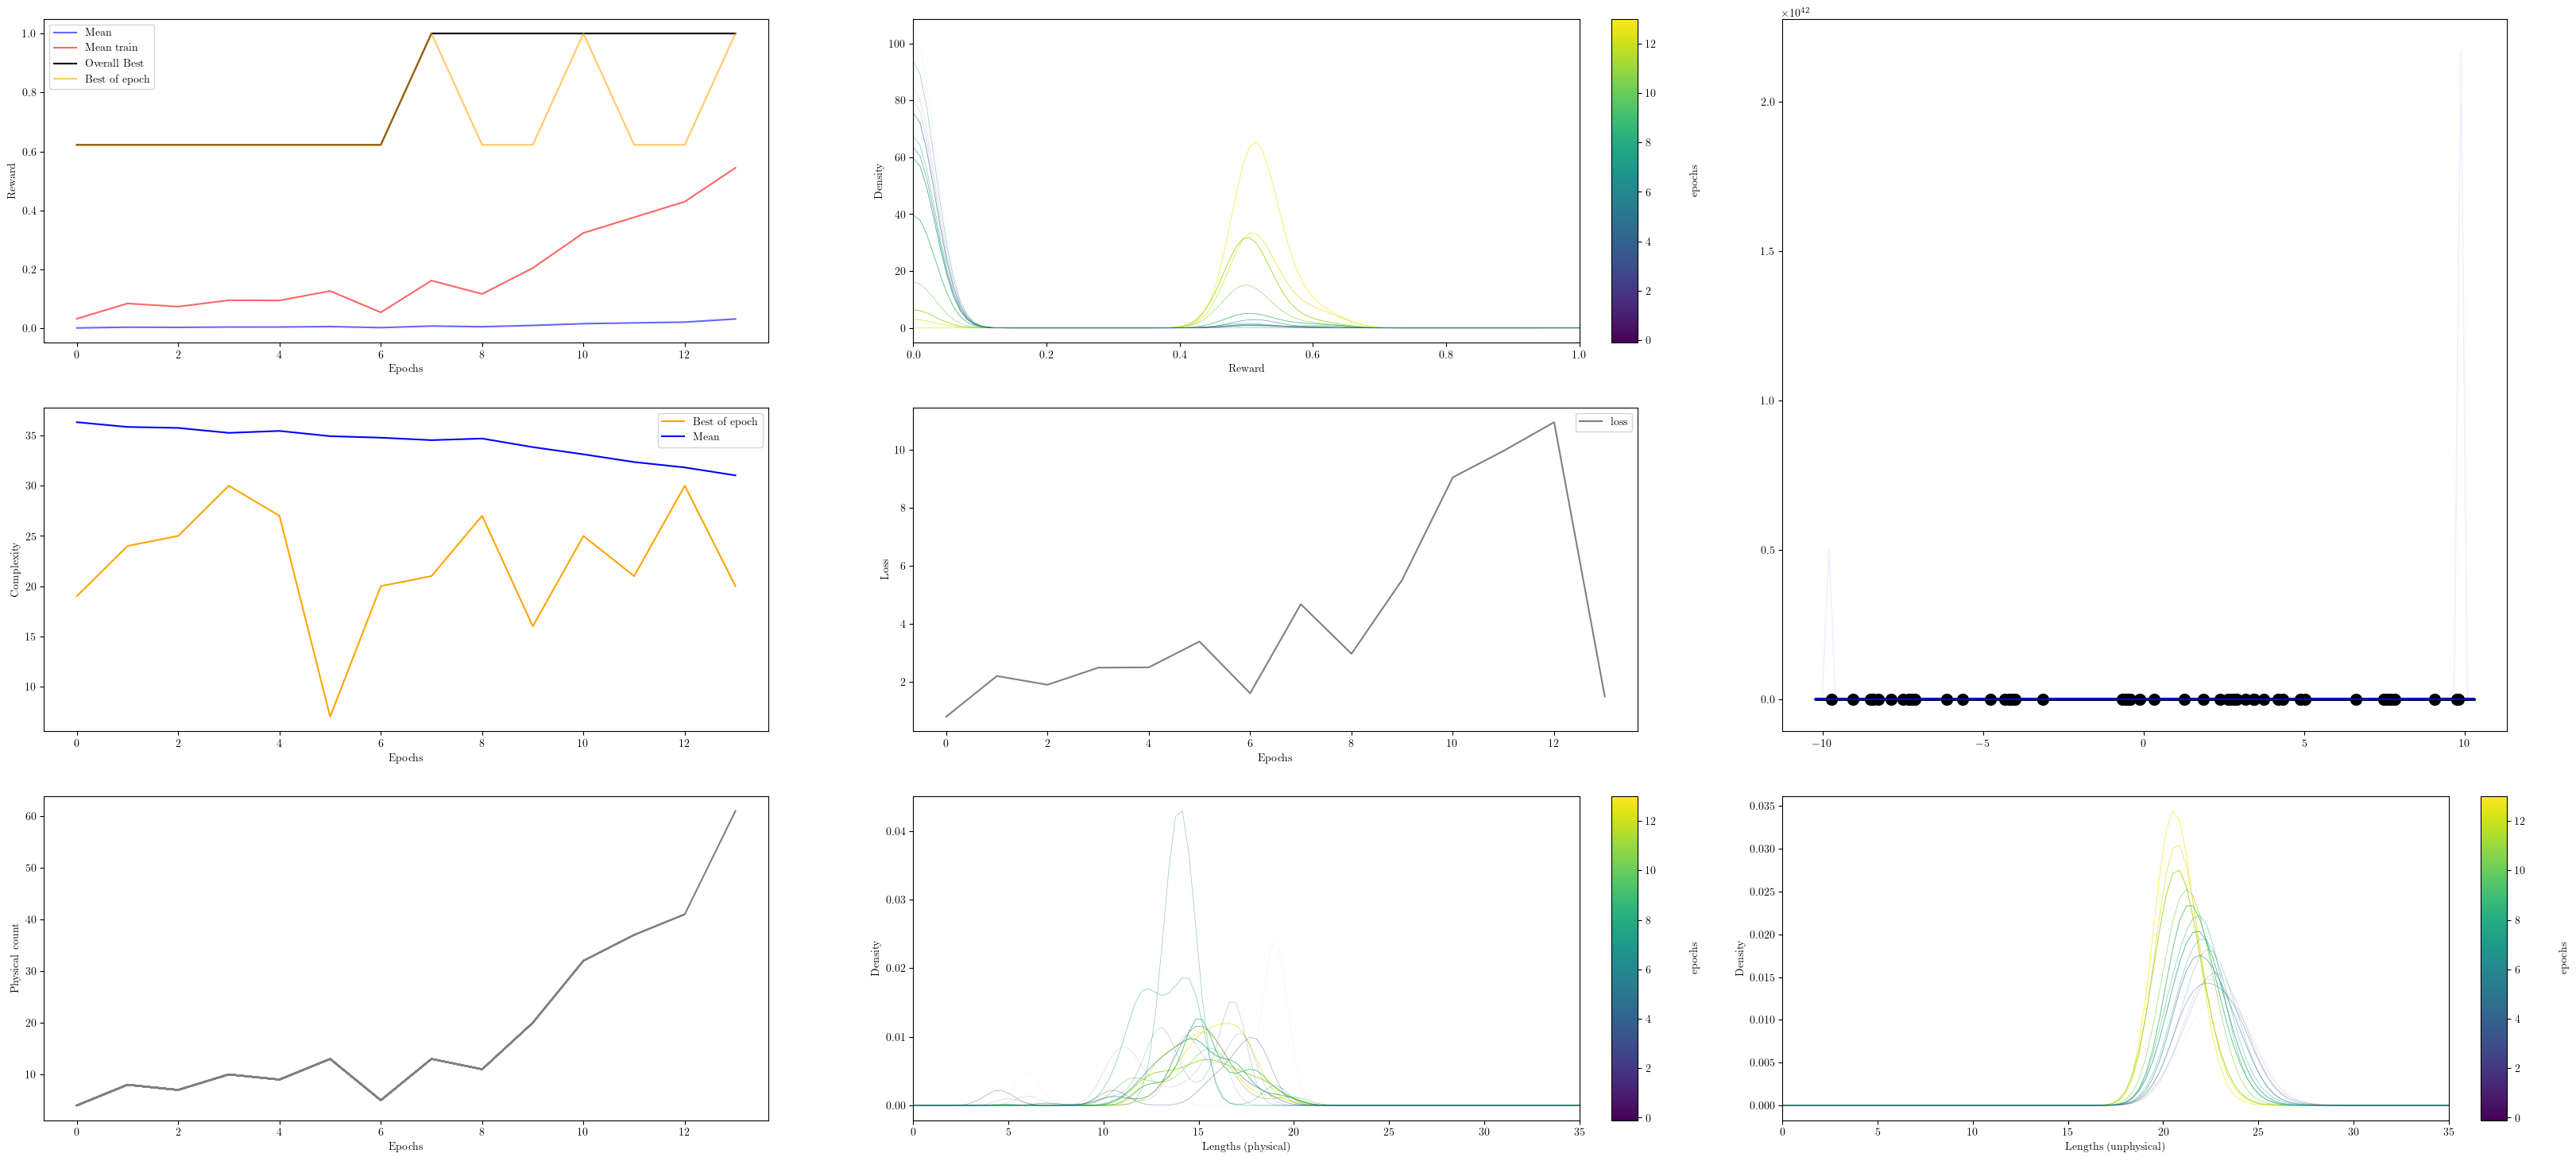

In [21]:
rewards, candidates = physo.fit(X, y, run_config)

## Results

### Run plot

In [ ]:
run_visualiser.make_visualisation()

### Pareto Front

In [ ]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 12,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [0, 15],
                      frac_delta_equ                = [0.03, 0.03],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    pareto_front_rmse = np.log(pareto_front_rmse)
    # Fig params
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')
    plt.rc('font', size=32)

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_rmse.min() + delta_ylim[0]
    ymax = pareto_front_rmse.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("log(RMSE)")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin), 
                     pareto_front_rmse[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.text(text_pos[0], text_pos[1], f'${latex_str}$', size = eq_text_size)

In [ ]:
plot_pareto_front(run_logger)


In [ ]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()


In [ ]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)

### Symbolic equivalence

In [ ]:
best_prog_sympy   = candidates[-1] .get_infix_sympy(do_simplify=True)
target_prog_sympy = target_program .get_infix_sympy(do_simplify=True)

In [ ]:
target_prog_sympy

In [ ]:
best_prog_sympy

In [ ]:
target_prog_sympy == best_prog_sympy

In [ ]:
hall_of_fame = run_logger.hall_of_fame

In [ ]:
for i in range(len(hall_of_fame)):
    print(hall_of_fame[i].get_infix_sympy(do_simplify=False))

In [ ]:
eq = hall_of_fame[i].get_infix_sympy(do_simplify=True)

In [ ]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)
    print("g", prog.free_const_values[0])
    print("m", prog.free_const_values[1])